# Aspect-based Sentiment Regression and Evaluation for Beer Reviews
### (Fine-tuned from a Pretrained BERT Model: GiRak/beer-sentiment-bert)

## 1. Import Libraries


In [28]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoConfig
import pandas as pd
import numpy as np

## 2. ABSARegressor: BERT-based Aspect Sentiment Regression Model
- Defines a PyTorch neural network for aspect-based sentiment regression.
- Uses a pre-trained BERT model as the encoder to extract text features.
- Adds a linear regression head to predict a continuous sentiment score for each aspect.
- Optionally allows freezing the BERT encoder during training for efficiency or transfer learning.
- Uses mean squared error (MSE) loss for regression tasks.

In [32]:
class ABSARegressor(nn.Module):
    def __init__(self, base_model_name="GiRak/beer-sentiment-bert", dropout_rate=0.1, freeze_encoder=True):
        super().__init__()
        config = AutoConfig.from_pretrained(base_model_name)
        self.bert = AutoModel.from_pretrained(base_model_name, config=config)
        if freeze_encoder:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.dropout = nn.Dropout(dropout_rate)
        hidden_size = config.hidden_size
        self.regressor = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        # Use **kwargs to accept all possible input parameters
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled = bert_outputs.pooler_output
        x = self.dropout(pooled)
        logits = self.regressor(x).squeeze(-1)
        output = {"logits": logits}
        if labels is not None:
            loss_fct = nn.MSELoss()
            output["loss"] = loss_fct(logits, labels)
        return output

## 3. BeerReviewAnalyzer: Aspect-based Sentiment Analysis Pipeline
### This class loads the fine-tuned BERT regression model and provides methods to:
- Preprocess and tokenize review text for each aspect (look, smell, taste, feel)
- Predict aspect-specific sentiment scores for a given review
- Aggregate predictions for all aspects in a review

In [33]:
from safetensors.torch import load_file

class BeerReviewAnalyzer:
    def __init__(self, model_path="./models/absa_bert_regressor"):
        # Load model and tokenizer
        self.model = ABSARegressor()  # Create model instance
        # Load the model weights using safetensors
        self.model.load_state_dict(load_file(f"{model_path}/model.safetensors"))
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model.eval()  # Set to evaluation mode
        
        # Define aspects
        self.aspects = ["look", "smell", "taste", "feel"]
        
    def preprocess_text(self, text, aspect):
        # Format input text
        input_text = f"{aspect}: {text}"
        
        # Tokenize
        inputs = self.tokenizer(
            input_text,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        return inputs
    
    def predict_score(self, text, aspect):
        # Preprocess
        inputs = self.preprocess_text(text, aspect)
        
        # Get prediction
        with torch.no_grad():
            model_inputs = {
                'input_ids': inputs['input_ids'],
                'attention_mask': inputs['attention_mask']
            }
            if 'token_type_ids' in inputs:
                model_inputs['token_type_ids'] = inputs['token_type_ids']
                
            outputs = self.model(**model_inputs)
            score = outputs["logits"].item()
            
        return score
    
    def analyze_review(self, text):
        results = {}
        for aspect in self.aspects:
            score = self.predict_score(text, aspect)
            results[aspect] = round(score, 2)
            
        return results

## 4. Example 1: Single Review Aspect-based Sentiment Analysis
- Instantiates the BeerReviewAnalyzer for aspect-based sentiment regression.
- Analyzes a single beer review, predicting sentiment scores for each aspect (look, smell, taste, feel).
- Prints the predicted scores for each aspect on a 5-point scale.

In [34]:
# Example 1: Single Review Analysis
analyzer = BeerReviewAnalyzer()

review = """
This beer has a beautiful golden color with a thick white head. 
The aroma is full of citrus and pine notes. 
The taste is balanced with a nice hop bitterness and malt sweetness. 
The mouthfeel is smooth and creamy.
"""

scores = analyzer.analyze_review(review)
print("Review Analysis Results:")
for aspect, score in scores.items():
    print(f"{aspect.capitalize()}: {score}/5.0")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Review Analysis Results:
Look: 3.75/5.0
Smell: 3.64/5.0
Taste: 3.62/5.0
Feel: 3.63/5.0


## 5.BeerReviewAnalyzer: Aspect-based Sentiment Analysis Pipeline
- Loads the fine-tuned BERT regression model and tokenizer for beer reviews.
- Preprocesses and tokenizes input review text for each aspect (look, smell, taste, feel).
- Predicts sentiment scores for each aspect using the regression model.
- Provides a method to analyze a review and return aspect-specific sentiment scores.

检查每个列的空值数量：
beer_id                0
username              10
date                   0
text                   0
look                 849
smell                849
taste                849
feel                 849
overall              849
score                  0
has_look               0
has_smell              0
has_taste              0
has_feel               0
mentioned_aspects      0
sentiment              0
dtype: int64

前1000条数据中的空值数量：
beer_id                0
username              10
date                   0
text                   0
look                 849
smell                849
taste                849
feel                 849
overall              849
score                  0
has_look               0
has_smell              0
has_taste              0
has_feel               0
mentioned_aspects      0
sentiment              0
dtype: int64

清理后的数据条数: 26853


/var/folders/fh/_tq_jbr50895yx1hkbgpct5m0000gn/T/ipykernel_51750/3281604474.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({



Overall Evaluation Metrics:
Mean Absolute Error (MAE): 0.611
Root Mean Squared Error (RMSE): 0.810
R-squared Score: 0.502

Evaluation Metrics by Aspect:

Look:
MAE: 0.565
RMSE: 0.747
R-squared: 0.390

Smell:
MAE: 0.591
RMSE: 0.776
R-squared: 0.554

Taste:
MAE: 0.681
RMSE: 0.904
R-squared: 0.509

Feel:
MAE: 0.609
RMSE: 0.805
R-squared: 0.488


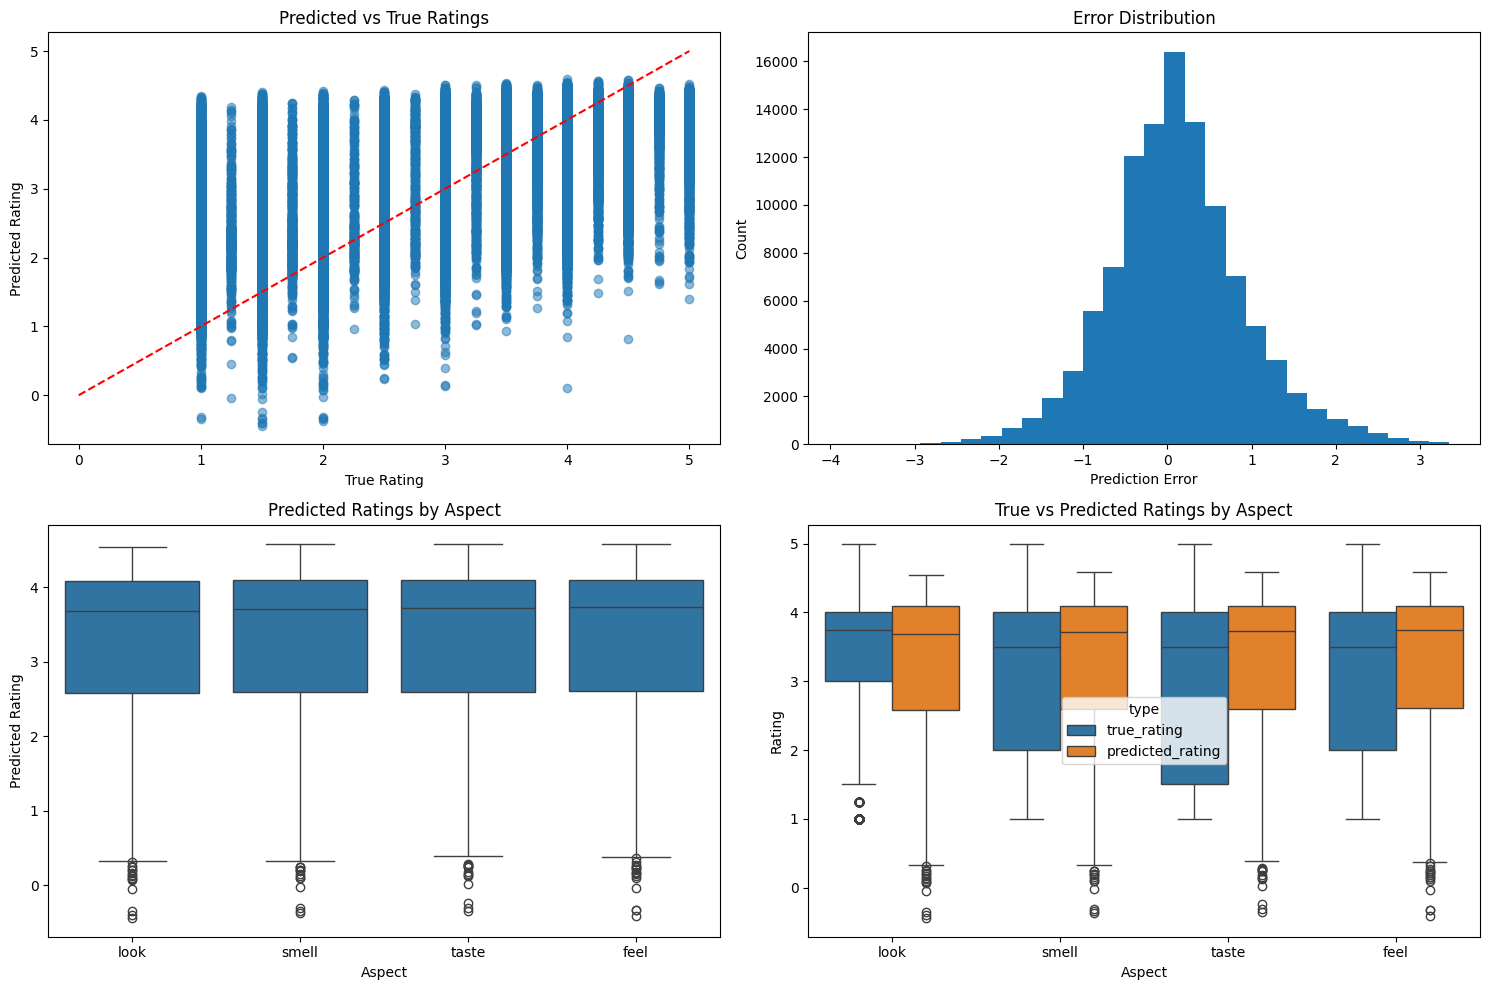


Results have been saved to 'model_evaluation_results.csv'

Sample Predictions:

Beer ID: 1428
Aspect: look
True Rating: 3.00
Predicted Rating: 2.06
Review:    poured into a tulip, it looks a nice golden yellow with a decent head that quickly disappears. th...

Beer ID: 1428
Aspect: look
True Rating: 3.00
Predicted Rating: 2.06
Review:    a- a dark yellow, the head was about thumb thick and did not go down much through out the drink s...

Beer ID: 1428
Aspect: smell
True Rating: 1.50
Predicted Rating: 2.11
Review:    poured into a tulip, it looks a nice golden yellow with a decent head that quickly disappears. th...

Beer ID: 1428
Aspect: smell
True Rating: 1.50
Predicted Rating: 2.11
Review:    a- a dark yellow, the head was about thumb thick and did not go down much through out the drink s...

Beer ID: 1428
Aspect: taste
True Rating: 1.50
Predicted Rating: 2.10
Review:    poured into a tulip, it looks a nice golden yellow with a decent head that quickly disappears. th...


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading dataset
df = pd.read_csv("../data/reviews_undersampled_dataset.csv")

print("Check the number of missing values in each column:")
print(df.isnull().sum())

df_test = df

# Check for missing values
print("\nNumber of missing values in the first 1000 rows:")
print(df_test.isnull().sum())

# Delete rows containing missing values
df_test = df_test.dropna(subset=['text', 'look', 'smell', 'taste', 'feel'])

print(f"\nNumber of rows after cleaning: {len(df_test)}")

# Create result storage DataFrame
results = pd.DataFrame(columns=['beer_id', 'aspect', 'true_rating', 'predicted_rating'])

# Analyze each review
for idx, row in df_test.iterrows():
    review = row['text']
    true_ratings = {
        'look': float(row['look']),    # Ensure conversion to float type
        'smell': float(row['smell']),
        'taste': float(row['taste']),
        'feel': float(row['feel'])
    }
    
    # Get model prediction
    predicted_ratings = analyzer.analyze_review(review)
    
    # Store results
    for aspect in ['look', 'smell', 'taste', 'feel']:
        results = pd.concat([results, pd.DataFrame({
            'beer_id': [row['beer_id']],
            'aspect': [aspect],
            'true_rating': [true_ratings[aspect]],
            'predicted_rating': [predicted_ratings[aspect]]
        })], ignore_index=True)

# Calculate overall evaluation metrics
mae = mean_absolute_error(results['true_rating'], results['predicted_rating'])
rmse = np.sqrt(mean_squared_error(results['true_rating'], results['predicted_rating']))
r2 = r2_score(results['true_rating'], results['predicted_rating'])

print("\nOverall Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared Score: {r2:.3f}")

# Calculate evaluation metrics by aspect
print("\nEvaluation Metrics by Aspect:")
for aspect in ['look', 'smell', 'taste', 'feel']:
    aspect_results = results[results['aspect'] == aspect]
    aspect_mae = mean_absolute_error(aspect_results['true_rating'], aspect_results['predicted_rating'])
    aspect_rmse = np.sqrt(mean_squared_error(aspect_results['true_rating'], aspect_results['predicted_rating']))
    aspect_r2 = r2_score(aspect_results['true_rating'], aspect_results['predicted_rating'])
    
    print(f"\n{aspect.capitalize()}:")
    print(f"MAE: {aspect_mae:.3f}")
    print(f"RMSE: {aspect_rmse:.3f}")
    print(f"R-squared: {aspect_r2:.3f}")

# Visualize prediction results
plt.figure(figsize=(15, 10))

# 1. Scatter plot of predicted vs true values
plt.subplot(2, 2, 1)
plt.scatter(results['true_rating'], results['predicted_rating'], alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--') 
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs True Ratings')

# 2. Histogram of prediction errors
plt.subplot(2, 2, 2)
errors = results['predicted_rating'] - results['true_rating']
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution')

# 3. Box plot by aspect
plt.subplot(2, 2, 3)
sns.boxplot(x='aspect', y='predicted_rating', data=results)
plt.xlabel('Aspect')
plt.ylabel('Predicted Rating')
plt.title('Predicted Ratings by Aspect')

# 4. Scatter plot of true vs predicted values
plt.subplot(2, 2, 4)
results_melted = pd.melt(results, id_vars=['beer_id', 'aspect'], 
                        value_vars=['true_rating', 'predicted_rating'],
                        var_name='type', value_name='rating')
sns.boxplot(x='aspect', y='rating', hue='type', data=results_melted)
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.title('True vs Predicted Ratings by Aspect')

plt.tight_layout()
plt.show()

# Save results to CSV file, including more information
results_with_info = pd.merge(
    results,
    df_test[['beer_id', 'username', 'date', 'text', 'overall', 'score']],
    on='beer_id',
    how='left'
)
results_with_info.to_csv('model_evaluation_results.csv', index=False)
print("\nResults have been saved to 'model_evaluation_results.csv'")

# Print some sample results
print("\nSample Predictions:")
sample_results = results_with_info.head(5)
for _, row in sample_results.iterrows():
    print(f"\nBeer ID: {row['beer_id']}")
    print(f"Aspect: {row['aspect']}")
    print(f"True Rating: {row['true_rating']:.2f}")
    print(f"Predicted Rating: {row['predicted_rating']:.2f}")
    print(f"Review: {row['text'][:100]}...") # Only show the first 100 characters